In [ ]:
import fxcmpy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyti.exponential_moving_average import exponential_moving_average as ema
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_rows = 4000
import trading
import algorithm 
import Backtesting 
from importlib import reload

In [4]:
con = fxcmpy.fxcmpy(config_file='fxcm.cfg')

ServerError: Can not connect to FXCM Server.

In [80]:
all_frequency = ['m1','m5', 'm15', 'm30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'D1', 'W1']
all_instrument = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CHF', 'AUD/USD', 'USD/CAD', 'NZD/USD']
# https://www.fxcm.com/markets/forex/#forex-currency-pairs           

# BACKTESTING

In [87]:
reload(Backtesting)
from Backtesting import BacktestingFXCM
reload(algorithm)
from algorithm import *
import time
reload(trading)
from trading import *

NameError: name 'trading' is not defined

calcul profit
gain : -1.943250


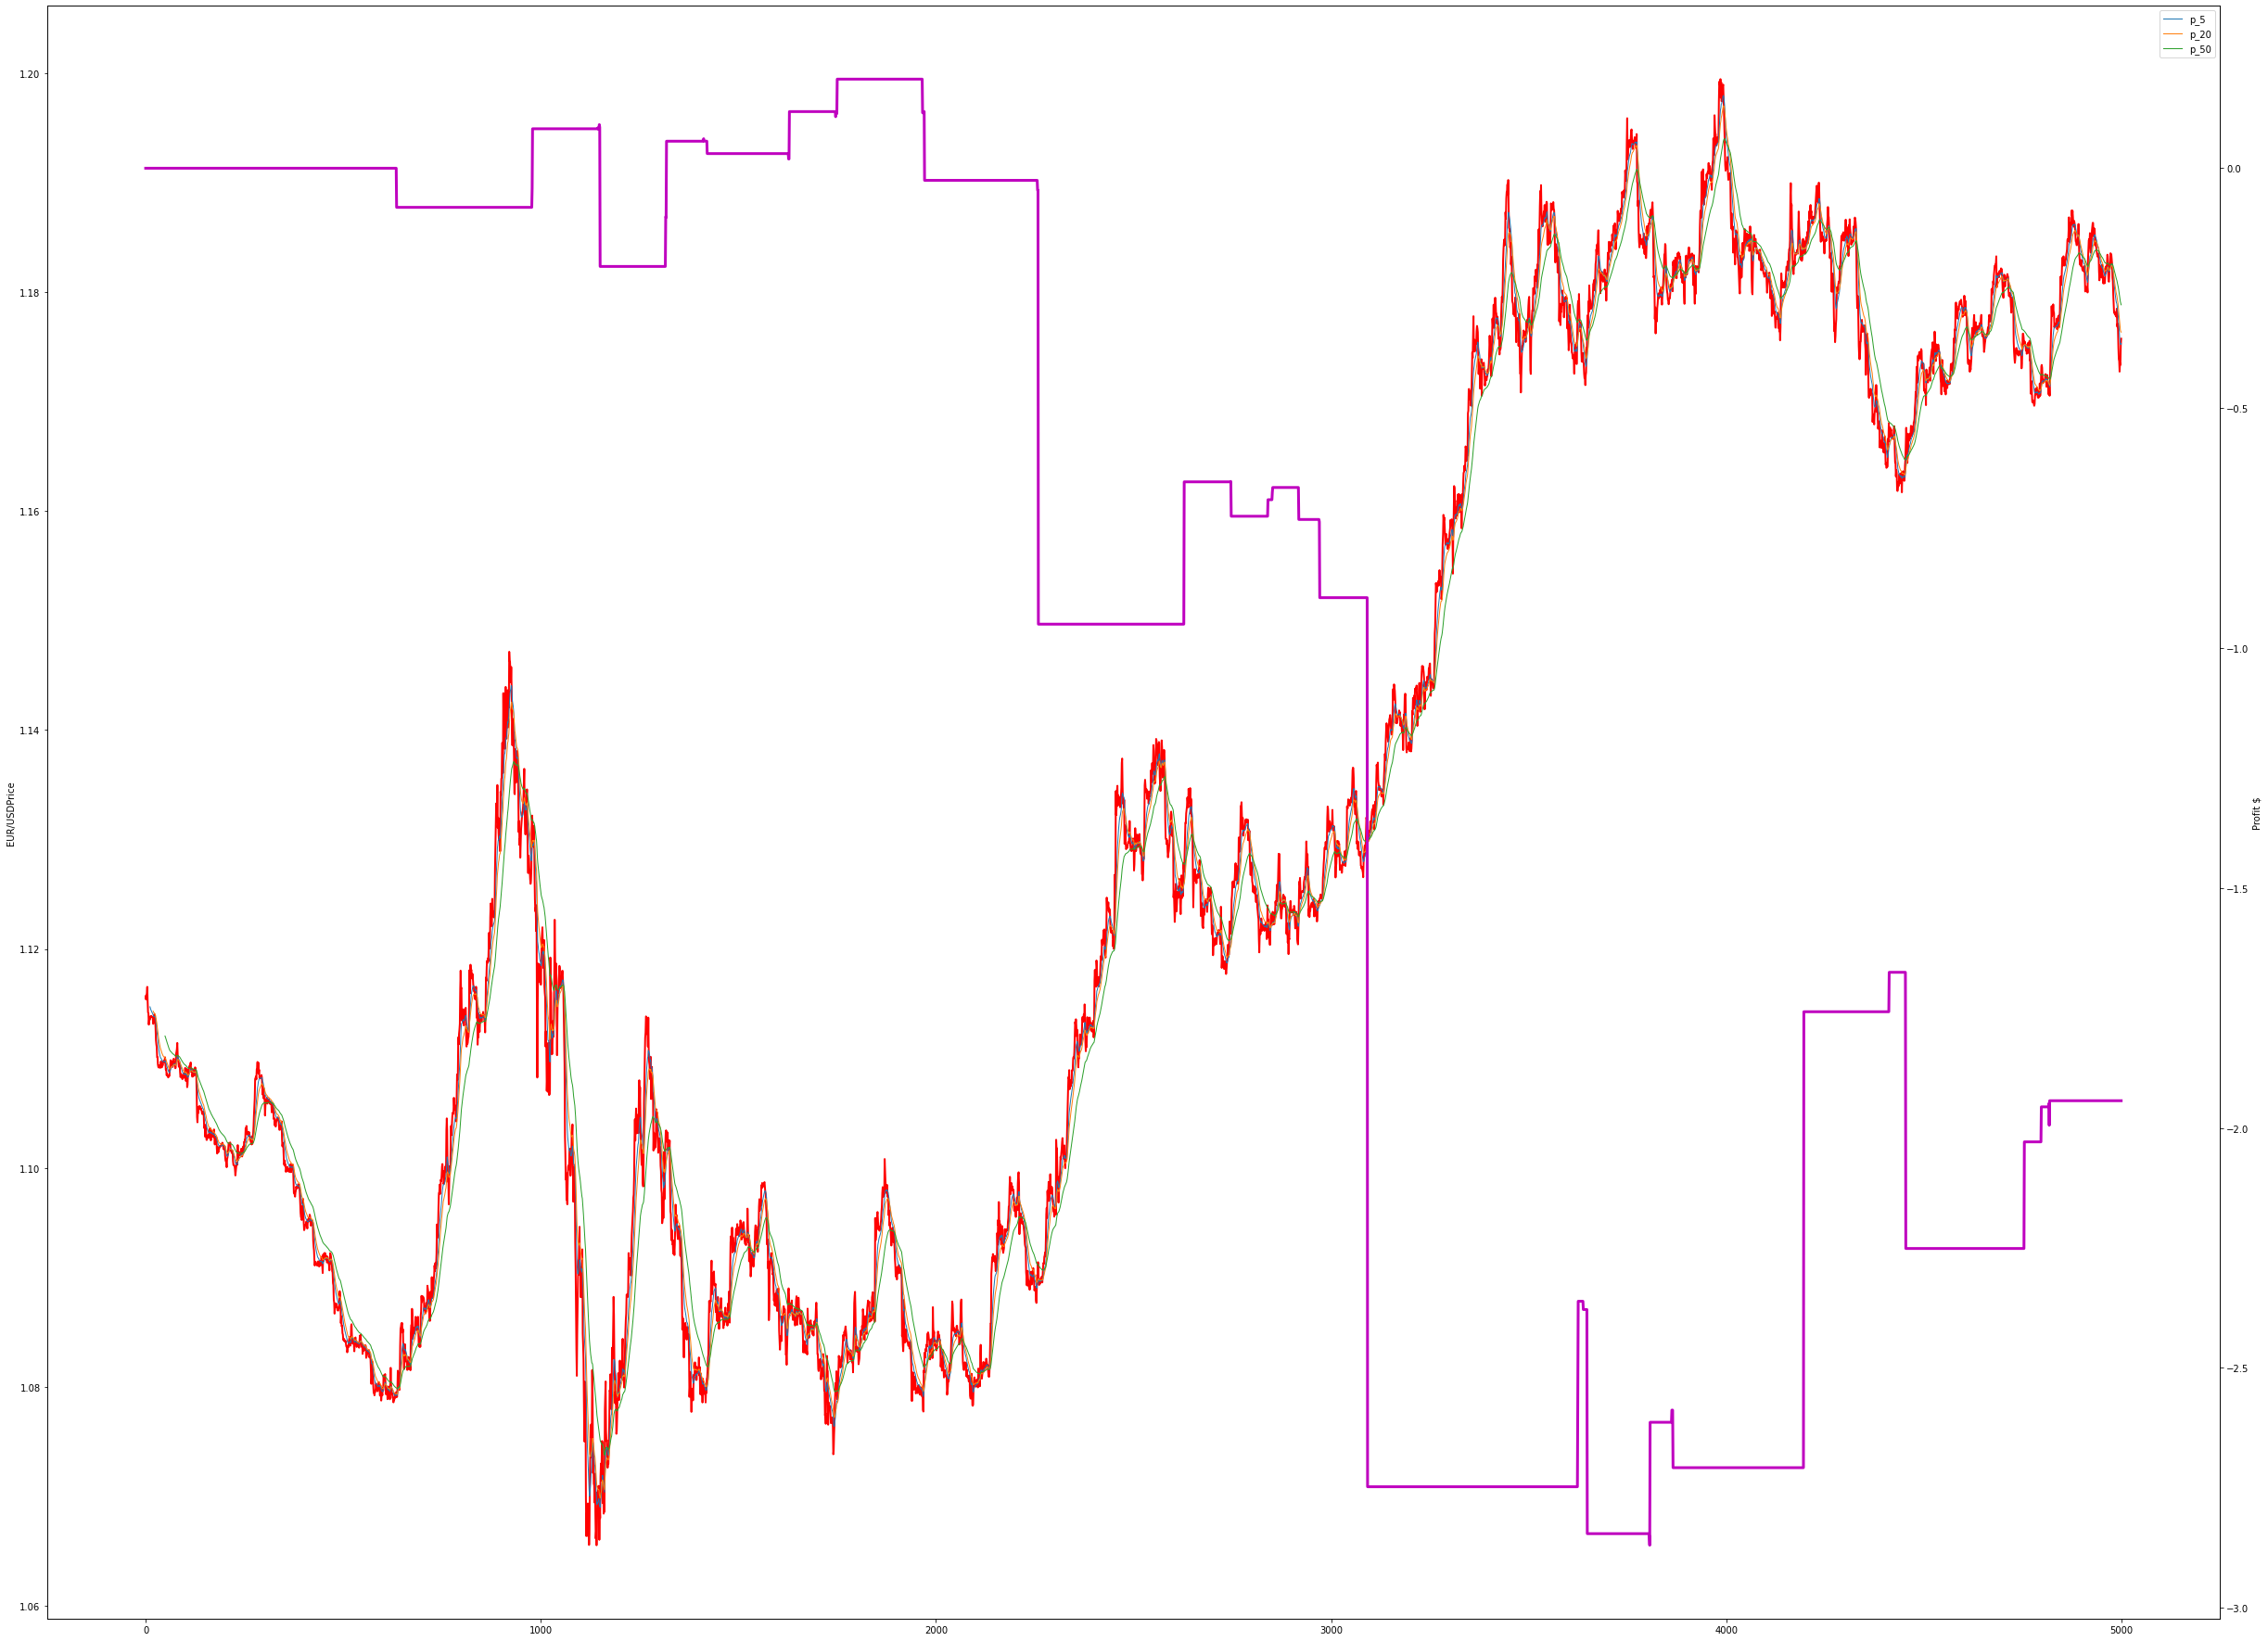

In [78]:
start = '2020-05-13 00:00:00'
end = '2020-10-27 00:00:00'
test = BacktestingFXCM("EUR/USD", "H1", start, end, con)
test.calculPositionIchimoku()
test.calculProfitv2()
print("gain : %f" %test.result['total'].iloc[-1])
test.plotting()


In [81]:
#start = '2019-01-01 00:00:00'
all_start_date = ['2020-10-26 00:00:00', '2020-10-26 00:00:00', '2020-10-26 00:00:00', '2020-10-23 00:00:00', '2020-10-20 00:00:00', '2020-10-10 00:00:00', '2020-09-26 00:00:00', '2020-09-15 00:00:00', '2020-09-01 00:00:00', '2020-08-20 00:00:00', '2020-07-01 00:00:00', '2020-01-01 00:00:00']
end = '2020-10-27 00:00:00'
rows = []
for instrument in all_instrument:
    counter_date = 0
    for frequency in all_frequency:
        start = time.time()
        testUSD = BacktestingFXCM(instrument, frequency, all_start_date[counter_date], end, con)
        #print("instrument = %s" %instrument)
        #print("frequency = %s" %frequency)
        testUSD.calculPositionIchimoku()
        testUSD.calculProfitv2()
        #print("gain : %f" %testUSD.result['total'].iloc[-1])    
        safe_ichi_res = testUSD.result['total'].iloc[-1]
        
        #testUSD.plotting()
        #testUSD.plottingICHI()
        testUSD.calculPositionEMAv()
        testUSD.calculProfit()
        safe_emav_res = testUSD.result['total'].iloc[-1]
        rows.append([instrument, frequency, safe_ichi_res, safe_emav_res, ( time.time() - start)]) 
        #print("gain : %f" %testUSD.result['total'].iloc[-1])
        counter_date += 1
ResultGlobal = pd.DataFrame(rows, columns=['instrument', 'period','ichimoku', 'emav', "time (s)"])
ResultGlobal

calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul profit
calcul

,instrument,period,ichimoku,emav,time (s)
0,EUR/USD,m1,9.3668,0.0,5.473514
1,EUR/USD,m5,7.3696,0.0,5.414599
2,EUR/USD,m15,5.5889,0.0,6.424701
3,EUR/USD,m30,-15.0611,0.0,6.394809
4,EUR/USD,H1,-19.4325,0.0,6.468864
5,EUR/USD,H2,-35.3427,0.0,6.173551
6,EUR/USD,H3,-19.4083,0.0,4.459645
7,EUR/USD,H4,-14.6987,0.0,3.545747
8,EUR/USD,H6,-1.8659,0.0,2.514603
9,EUR/USD,H8,-3.5842,0.0,1.697475


In [86]:
ResultGlobal.sort_values(['instrument', 'ichimoku'], ascending=[True, False])

,instrument,period,ichimoku,emav,time (s)
58,AUD/USD,D1,169.8997,0.0,5.300019
59,AUD/USD,W1,64.4035,0.0,1.618615
50,AUD/USD,m15,7.9091,0.0,6.848898
48,AUD/USD,m1,3.3349,0.0,7.061494
49,AUD/USD,m5,1.3262,0.0,7.431566
57,AUD/USD,H8,1.2711,0.0,1.682370
56,AUD/USD,H6,-0.6263,0.0,2.503730
51,AUD/USD,m30,-1.4361,0.0,7.453766
55,AUD/USD,H4,-8.2195,0.0,3.085598
54,AUD/USD,H3,-9.7733,0.0,4.423355


# TRADING

In [96]:
all_market = []
all_market.append(tradeFXCM('EUR/USD', 'm1', con))

2020-10-28 17:46:01.992630


In [ ]:
while 1:
    for market in all_market:
        duration = datetime.datetime.now() - market.time_update
        duration_in_s = duration.total_seconds()
        #check one minute
        if market.frequency == 'm1':
            if divmod(duration_in_s, 60)[0] == 1:
                market.update(con)
            #decisionEMAv(self.data, self.EMAv)

                     askclose  bidclose  askhigh   asklow  askopen
date                                                              
2020-10-28 16:43:00   1.17491   1.17479  1.17496  1.17476  1.17491
2020-10-28 16:44:00   1.17498   1.17487  1.17499  1.17488  1.17491
2020-10-28 16:45:00   1.17493   1.17481  1.17504  1.17490  1.17498
2020-10-28 16:46:00   1.17497   1.17486  1.17506  1.17492  1.17493
2020-10-28 16:47:00   1.17505   1.17494  1.17509  1.17497  1.17497
ma valeur index qui marche pas
2020-10-28 16:47:00
                     askclose  bidclose  askhigh   asklow  askopen
date                                                              
2020-10-28 16:47:00   1.17505   1.17494  1.17509  1.17497  1.17497


In [ ]:
con.close()